In [31]:
grid_file = '/home/benr/src/ssm-analysis/SSM_Grid/ssm_grid.2dm'

import configparser
import re
import os

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from fvcom import FvcomGrid, Transect, ControlVolume

In [2]:
data = Dataset('results/doxg.nc')
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2014-01-01 00:00:00
    dimensions(sizes): time(4380), node(3137), nele(4129), siglay(10), siglev(11)
    variables(dimensions): int32 node(node), float32 h(node), float32 x(node), float32 y(node), int32 nele(nele), float32 time(time), float32 siglay(siglay), float32 siglev(siglev), float32 zeta(time, node), float32 controlDOXG(time, siglay, node), float32 c2936DOXG(time, siglay, node), float32 q5c2936DOXG(time, siglay, node), float32 q5c454DOXG(time, siglay, node), float32 q1c454DOXG(time, siglay, node), float32 q1c2936DOXG(time, siglay, node), float32 q5c15DOXG(time, siglay, node), float32 q9c454DOXG(time, siglay, node), float32 q9c2936DOXG(time, siglay, node), float32 q1c15DOXG(time, siglay, node), float32 q3c454DOXG(time, siglay, node), float32 q3c15DOXG(time, siglay, node), float32 q3c2936DOXG(time, siglay, node), float32 q5c10DOXG(time, siglay, node), float32 q5c20DOXG(time, sig

In [23]:
def sort(vs):
    r = re.compile('q([1-9])c([0-9]+)')
    dec = []
    for v in vs:
        if v[-4:] != 'DOXG':
            continue
        n = v[:-4] # Remove 'DOXG'
        m = r.match(n)
        if m:
            q = m.group(1)
            c = m.group(2)
            if c == '454':
                c = '0' + c
        else:
            if n == 'control':
                q = '0'
                c = '0'
            else:
                q = '0'
                c = '1'
        dec.append((q, c, v))
    dec.sort()
    return [v for q, c, v in dec]

sort(data.variables)

['controlDOXG',
 'c2936DOXG',
 'q1c454DOXG',
 'q1c15DOXG',
 'q1c2936DOXG',
 'q3c454DOXG',
 'q3c15DOXG',
 'q3c2936DOXG',
 'q5c454DOXG',
 'q5c10DOXG',
 'q5c15DOXG',
 'q5c20DOXG',
 'q5c2936DOXG',
 'q9c454DOXG',
 'q9c15DOXG',
 'q9c2936DOXG']

In [3]:
grid = FvcomGrid.from_mesh(grid_file)
areas = grid.tces_gdf().loc[data['node'][:]].area
areas

4478     1.290208e+06
4479     1.012244e+06
4480     1.511056e+06
4481     1.856297e+06
4482     1.190541e+06
             ...     
15989    2.452663e+05
15993    2.198963e+05
15994    1.809223e+05
16000    9.728483e+04
16003    2.510567e+05
Length: 3137, dtype: float64

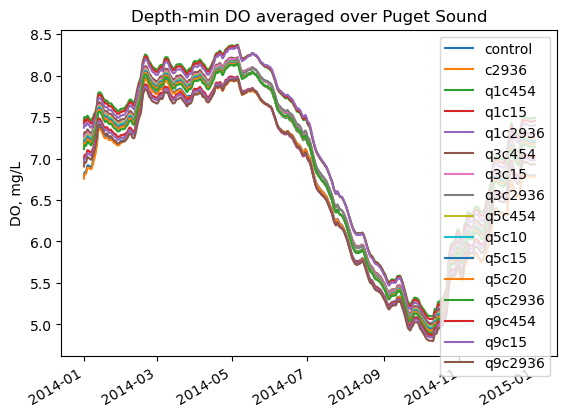

In [24]:
dates = pd.Timestamp(data.model_start) + pd.to_timedelta(data['time'][:], 'D')
fig, ax = plt.subplots()
mindo_avgs = {}
for v in sort(data.variables):
    name = v[:-4]
    ser = pd.Series(np.average(data[v][:].min(axis=1), axis=1, weights=areas), index=dates)
    ser.rolling('1D').mean().plot(ax=ax, label=name)
    mindo_avgs[name] = ser
mindo_avgs_df = pd.DataFrame(mindo_avgs)
ax.set(title='Depth-min DO averaged over Puget Sound', ylabel='DO, mg/L')
ax.legend()

In [25]:
mindo_avgs_df.mean()

control    6.703270
c2936      6.691693
q1c454     7.101780
q1c15      7.083131
q1c2936    7.057404
q3c454     6.954268
q3c15      6.934861
q3c2936    6.907911
q5c454     6.903721
q5c10      6.893546
q5c15      6.884079
q5c20      6.874613
q5c2936    6.856754
q9c454     6.739338
q9c15      6.719256
q9c2936    6.691056
dtype: float64

In [27]:
mindo_avgs_df.to_excel('results/puget_sound/do_min_avg.xlsx')

In [29]:
sections_file = 'inlet_sections_aurora.ini'
sections_config = configparser.ConfigParser()
sections_config.read(sections_file)

# names of sections that bound each control volume
cv_bounds = {
    'Penn Cove': ['PennCove'],
    'Holmes Harbor': ['HolmesHbr'],
    'Crescent Bay': ['CrescentBy'],
    'Carr Inlet': ['CarrInl'],
    'Case Inlet': ['CaseInl'],
    'Elliot Bay': ['ElliotBy'],
    'Commencement Bay': ['CommenceBy'],
    'Dabob Bay': ['DabobBy'],
    'Port Susan': ['PtSusan','StillaguamishSouthFork','StillaguamishPassSouth'],
    'Dyes Inlet': ['DyesInl'],
    'Sinclair Inlet': ['SinclairInl'],
    'Quartermaster Harbor': ['QtrHbr'],
    'Lynch Cove': ['LynchCove']
}

In [32]:
dirname = lambda n: n.lower().replace(' ', '_')

cvs = {}
for name, sectnames in cv_bounds.items():
    transects = []
    display(name)
    for sn in sectnames:
        waypoints = np.array(sections_config[sn]['waypoints'].split(' ')).astype(int)
        t = Transect.shortest(grid, waypoints)
        transects.append(t)
    cvs[name] = ControlVolume.from_transects(transects, calc=True)
    os.mkdir(f'results/{dirname(name)}')
    display(len(cvs[name].nodes))

'Penn Cove'

14

'Holmes Harbor'

26

'Crescent Bay'

10

'Carr Inlet'

157

'Case Inlet'

100

'Elliot Bay'

166

'Commencement Bay'

60

'Dabob Bay'

104

'Port Susan'

190

'Dyes Inlet'

42

'Sinclair Inlet'

16

'Quartermaster Harbor'

40

'Lynch Cove'

96

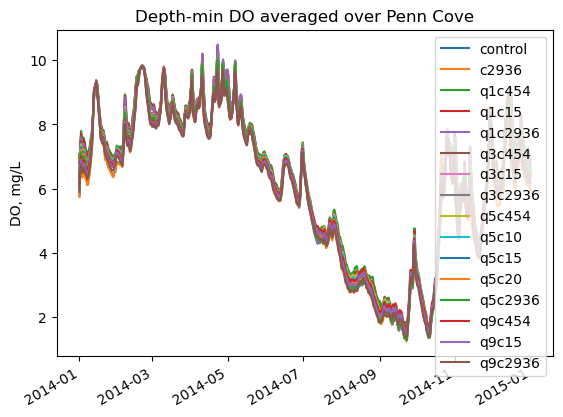

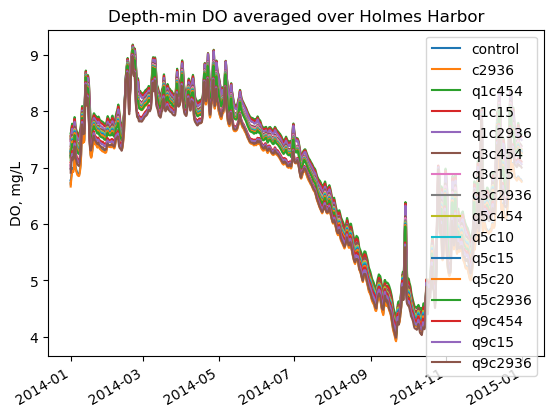

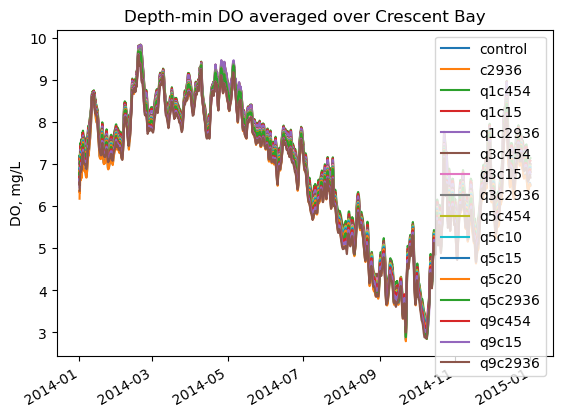

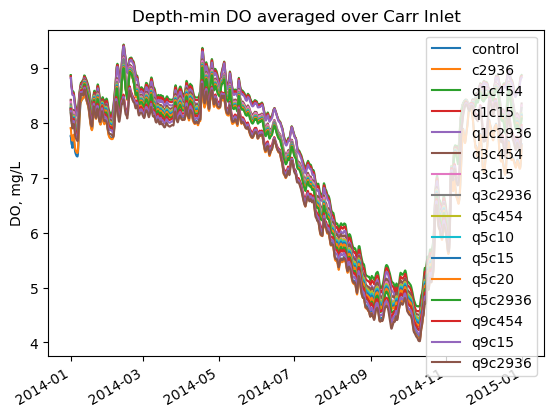

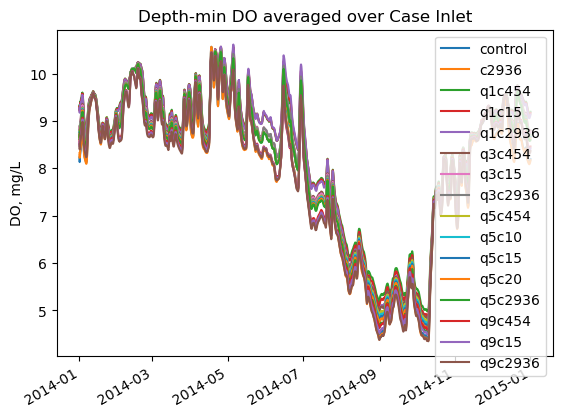

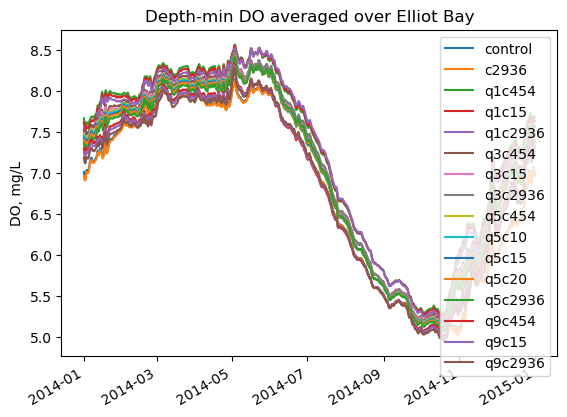

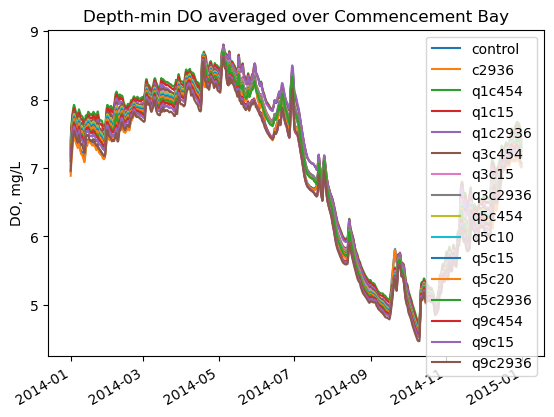

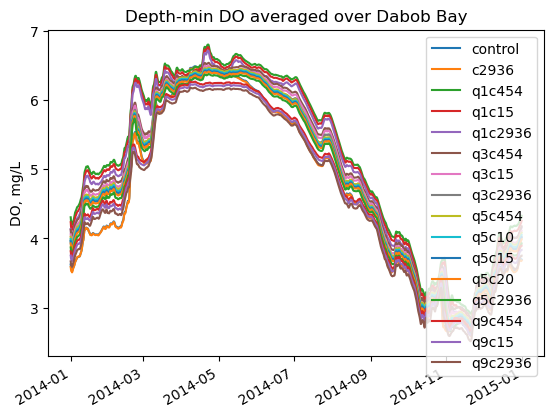

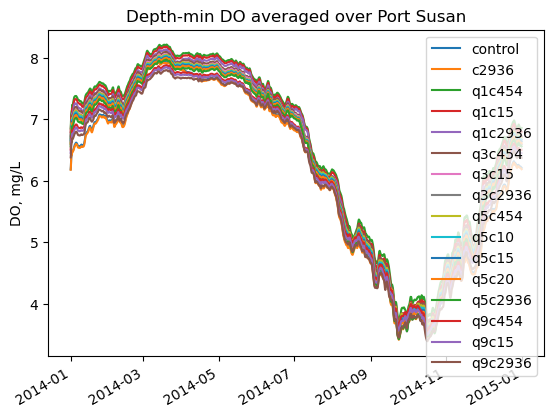

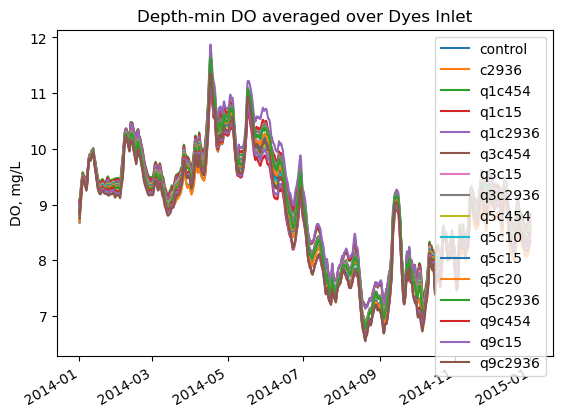

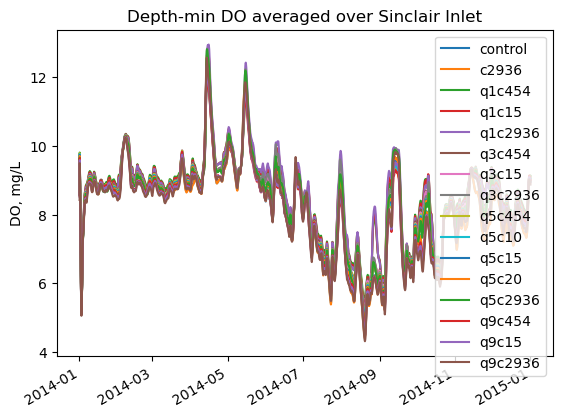

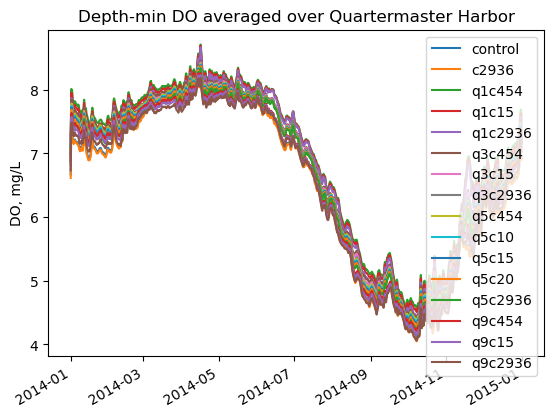

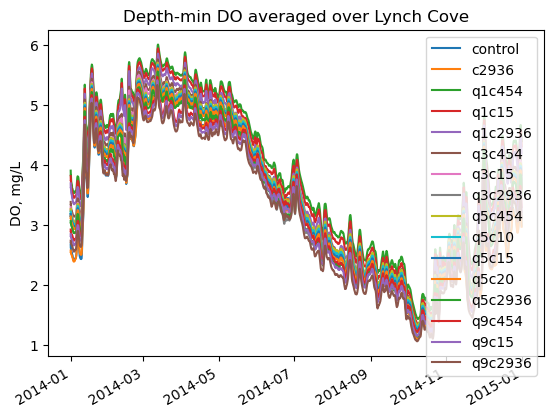

In [33]:
mindo_avgs_by_cv = {}
for cvname,cv in cvs.items():
    fig, ax = plt.subplots()
    mindo_avgs = {}
    idxs = np.searchsorted(data['node'][:], np.array(list(cv.nodes & set(data['node'][:]))))
    for v in sort(data.variables):
        name = v[:-4]
        ser = pd.Series(np.average(data[v][:,:,idxs].min(axis=1), axis=1, weights=areas.iloc[idxs]), index=dates)
        ser.rolling('1D').mean().plot(ax=ax, label=name)
        mindo_avgs[name] = ser
    mindo_avgs_by_cv[cvname] = pd.DataFrame(mindo_avgs)
    ax.set(title=f'Depth-min DO averaged over {cvname}', ylabel='DO, mg/L')
    ax.legend()

In [34]:
for name,df in mindo_avgs_by_cv.items():
    display(name)
    display(df.mean())
    df.to_excel(f'results/{dirname(name)}/do_min_avg.xlsx')

'Penn Cove'

control    6.004068
c2936      5.972940
q1c454     6.435361
q1c15      6.353404
q1c2936    6.241634
q3c454     6.325051
q3c15      6.246858
q3c2936    6.138803
q5c454     6.289066
q5c10      6.249280
q5c15      6.212091
q5c20      6.174928
q5c2936    6.105523
q9c454     6.159325
q9c15      6.086842
q9c2936    5.985384
dtype: float64

'Holmes Harbor'

control    6.677622
c2936      6.658946
q1c454     7.150786
q1c15      7.111025
q1c2936    7.055942
q3c454     7.006620
q3c15      6.967448
q3c2936    6.912778
q5c454     6.955421
q5c10      6.935420
q5c15      6.916729
q5c20      6.897916
q5c2936    6.862262
q9c454     6.780102
q9c15      6.742285
q9c2936    6.688982
dtype: float64

'Crescent Bay'

control    6.665760
c2936      6.645313
q1c454     7.102984
q1c15      7.054083
q1c2936    6.986213
q3c454     6.969925
q3c15      6.922415
q3c2936    6.855802
q5c454     6.919825
q5c10      6.895461
q5c15      6.872619
q5c20      6.849685
q5c2936    6.806400
q9c454     6.764247
q9c15      6.719041
q9c2936    6.655137
dtype: float64

'Carr Inlet'

control    7.035417
c2936      7.012698
q1c454     7.640402
q1c15      7.601456
q1c2936    7.547821
q3c454     7.455965
q3c15      7.413876
q3c2936    7.355675
q5c454     7.389102
q5c10      7.366792
q5c15      7.346008
q5c20      7.325208
q5c2936    7.286280
q9c454     7.167427
q9c15      7.121016
q9c2936    7.056092
dtype: float64

'Case Inlet'

control    7.889101
c2936      7.866671
q1c454     8.372352
q1c15      8.345837
q1c2936    8.309260
q3c454     8.210612
q3c15      8.180236
q3c2936    8.138278
q5c454     8.152100
q5c10      8.135673
q5c15      8.120385
q5c20      8.105099
q5c2936    8.076492
q9c454     7.948000
q9c15      7.912472
q9c2936    7.862823
dtype: float64

'Elliot Bay'

control    6.787803
c2936      6.774735
q1c454     7.230717
q1c15      7.214755
q1c2936    7.192292
q3c454     7.084396
q3c15      7.067241
q3c2936    7.043167
q5c454     7.032312
q5c10      7.023232
q5c15      7.014811
q5c20      7.006323
q5c2936    6.990207
q9c454     6.870723
q9c15      6.852157
q9c2936    6.825860
dtype: float64

'Commencement Bay'

control    6.890553
c2936      6.869114
q1c454     7.164856
q1c15      7.136271
q1c2936    7.096619
q3c454     7.046586
q3c15      7.017372
q3c2936    6.976678
q5c454     7.005207
q5c10      6.989884
q5c15      6.975726
q5c20      6.961478
q5c2936    6.934525
q9c454     6.873720
q9c15      6.843497
q9c2936    6.800997
dtype: float64

'Dabob Bay'

control    4.670967
c2936      4.658163
q1c454     5.163166
q1c15      5.110846
q1c2936    5.040214
q3c454     4.992122
q3c15      4.942295
q3c2936    4.874228
q5c454     4.910670
q5c10      4.885294
q5c15      4.861589
q5c20      4.838217
q5c2936    4.794425
q9c454     4.717001
q9c15      4.670599
q9c2936    4.606071
dtype: float64

'Port Susan'

control    6.137657
c2936      6.116618
q1c454     6.546543
q1c15      6.493447
q1c2936    6.420340
q3c454     6.425842
q3c15      6.375372
q3c2936    6.305339
q5c454     6.385598
q5c10      6.359991
q5c15      6.336087
q5c20      6.312164
q5c2936    6.267194
q9c454     6.244500
q9c15      6.198559
q9c2936    6.133975
dtype: float64

'Dyes Inlet'

control    8.785563
c2936      8.778762
q1c454     9.108730
q1c15      9.119489
q1c2936    9.134430
q3c454     8.974195
q3c15      8.979327
q3c2936    8.986542
q5c454     8.922477
q5c10      8.924010
q5c15      8.925579
q5c20      8.927177
q5c2936    8.930241
q9c454     8.763797
q9c15      8.760747
q9c2936    8.756589
dtype: float64

'Sinclair Inlet'

control    8.152830
c2936      8.139170
q1c454     8.592804
q1c15      8.585442
q1c2936    8.574030
q3c454     8.422154
q3c15      8.406667
q3c2936    8.384656
q5c454     8.358288
q5c10      8.348545
q5c15      8.339728
q5c20      8.330717
q5c2936    8.313866
q9c454     8.173314
q9c15      8.147734
q9c2936    8.112721
dtype: float64

'Quartermaster Harbor'

control    6.506397
c2936      6.482978
q1c454     6.929135
q1c15      6.886227
q1c2936    6.826750
q3c454     6.781803
q3c15      6.738020
q3c2936    6.677070
q5c454     6.732565
q5c10      6.709778
q5c15      6.688613
q5c20      6.667339
q5c2936    6.627291
q9c454     6.596230
q9c15      6.552649
q9c2936    6.491243
dtype: float64

'Lynch Cove'

control    3.332320
c2936      3.323103
q1c454     3.909009
q1c15      3.819463
q1c2936    3.701425
q3c454     3.616969
q3c15      3.533515
q3c2936    3.422095
q5c454     3.592094
q5c10      3.549653
q5c15      3.510378
q5c20      3.471943
q5c2936    3.400902
q9c454     3.355254
q9c15      3.281094
q9c2936    3.180295
dtype: float64

In [35]:
timestep = data['time'][2] - data['time'][1]

def calc_duration(data):
    """Calculate the total time that this region spent with a hypoxic DO"""
    return np.count_nonzero(data < 2) * timestep

durations = {}
vs = []
for v in sort(data.variables):
    vs.append(v[:-4])
for cvname,cv in cvs.items():
    durations[cvname] = []
    idxs = np.searchsorted(data['node'][:], np.array(list(cv.nodes & set(data['node'][:]))))
    for v in vs:
        durations[cvname].append(calc_duration(data[v + 'DOXG'][:,:,idxs].min(axis=(1,2))))
durations_df = pd.DataFrame(durations, index=vs)

In [36]:
durations_df

,Penn Cove,Holmes Harbor,Crescent Bay,Carr Inlet,Case Inlet,Elliot Bay,Commencement Bay,Dabob Bay,Port Susan,Dyes Inlet,Sinclair Inlet,Quartermaster Harbor,Lynch Cove
control,37.666664,0.0,0.0,0.0,0.0,0.0,0.0,13.166666,8.000000,0.0,0.666667,0.0,180.249989
c2936,37.916664,0.0,0.0,0.0,0.0,0.0,0.0,13.916666,8.749999,0.0,1.083333,0.0,179.916656
q1c454,29.083332,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.083333,0.0,0.000000,0.0,129.416659
q1c15,32.583331,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.166666,0.0,0.000000,0.0,139.416658
q1c2936,38.499998,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,8.083333,0.0,0.000000,0.0,150.916658
q3c454,30.833331,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.750000,0.0,0.000000,0.0,145.333325
q3c15,34.083331,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.833333,0.0,0.000000,0.0,155.916657
q3c2936,37.583331,0.0,0.0,0.0,0.0,0.0,0.0,1.416667,9.333333,0.0,0.250000,0.0,168.583323
q5c454,30.583332,0.0,0.0,0.0,0.0,0.0,0.0,0.416667,2.000000,0.0,0.000000,0.0,143.583325
q5c10,32.749998,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3.000000,0.0,0.083333,0.0,148.749991


In [37]:
durations_df.to_excel('results/hypoxic_durations.xlsx')

In [42]:
extract_bottom = lambda v: data[v][:,-1,:].data
def calc_area(data, t):
    return areas.loc[data[t,:] < 2].sum() / 1e6

bottom_hypoxic_areas = {}
for v in sort(data.variables):
    d = extract_bottom(v)
    bottom_hypoxic_areas[v] = np.zeros(d.shape[0])
    for t in range(d.shape[0]):
        bottom_hypoxic_areas[v][t] = calc_area(d, t)

# Assemble a DataFrame of all the hypoxic area timeseries for each variable
bottom_hypoxic_areas_df = pd.DataFrame(bottom_hypoxic_areas, index=dates)

In [45]:
bottom_hypoxic_areas_df.to_excel("results/puget_sound/bottom_hypoxic_area_km2.xlsx")

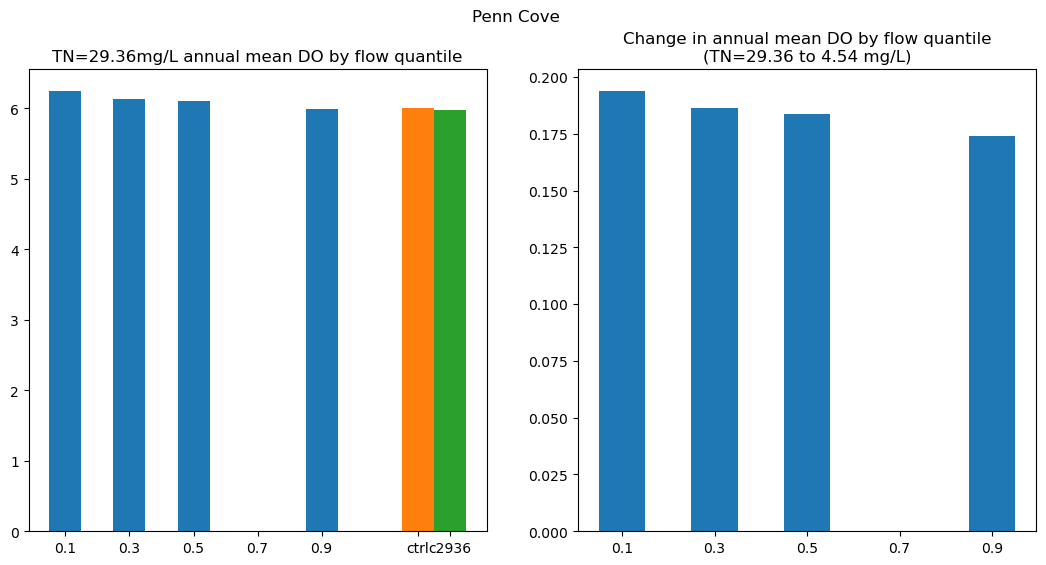

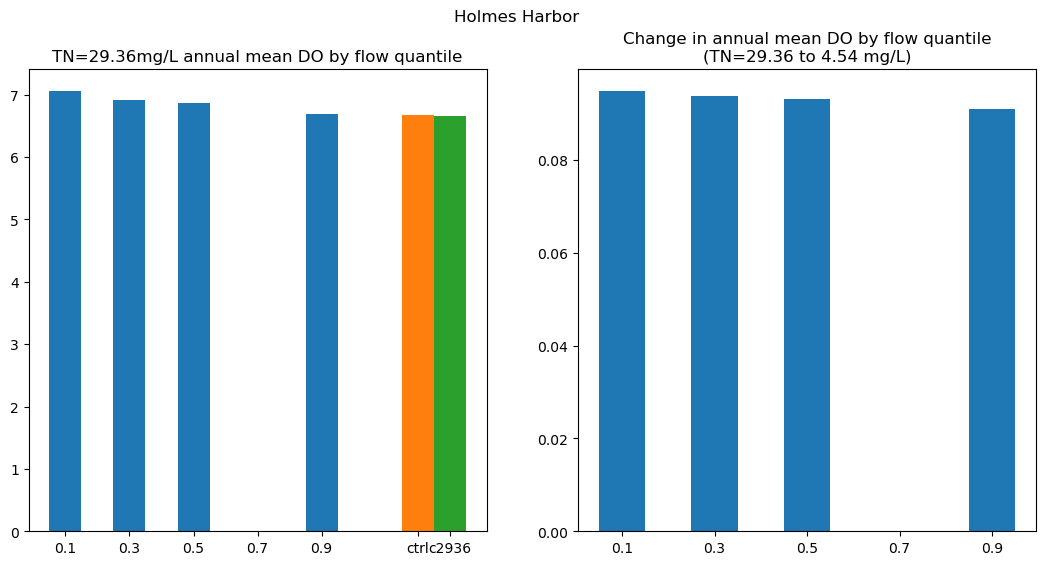

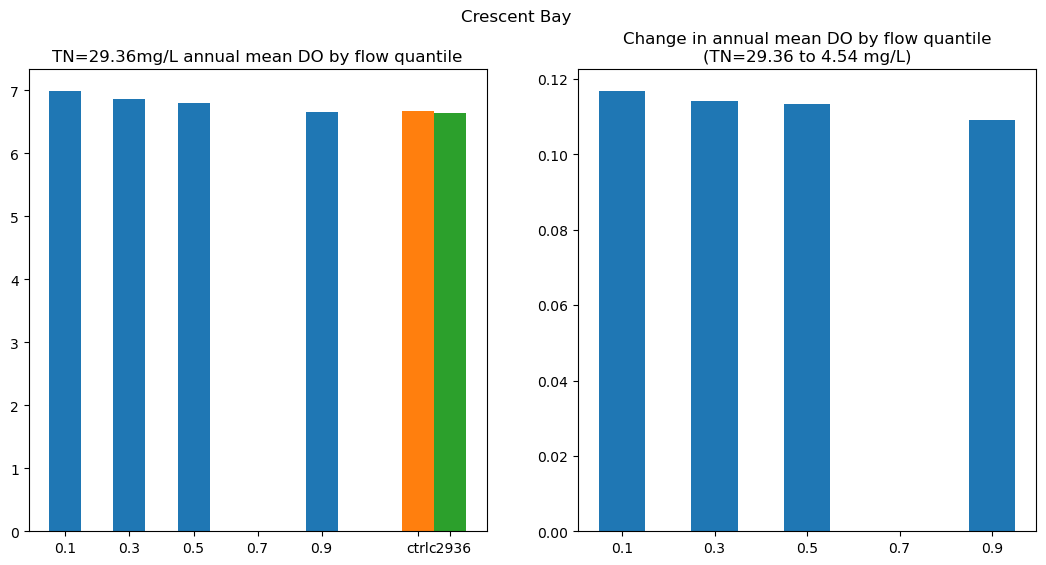

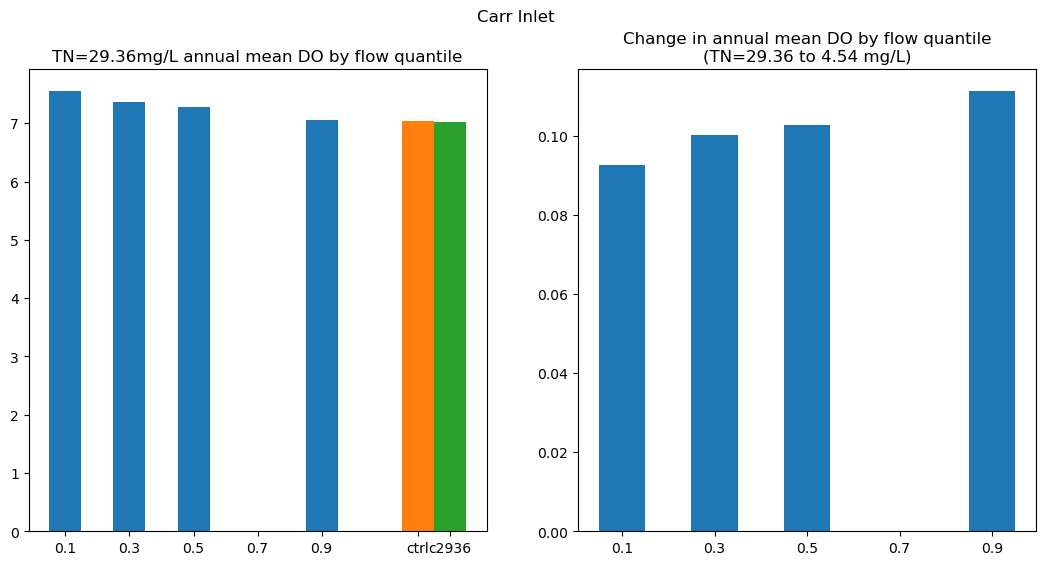

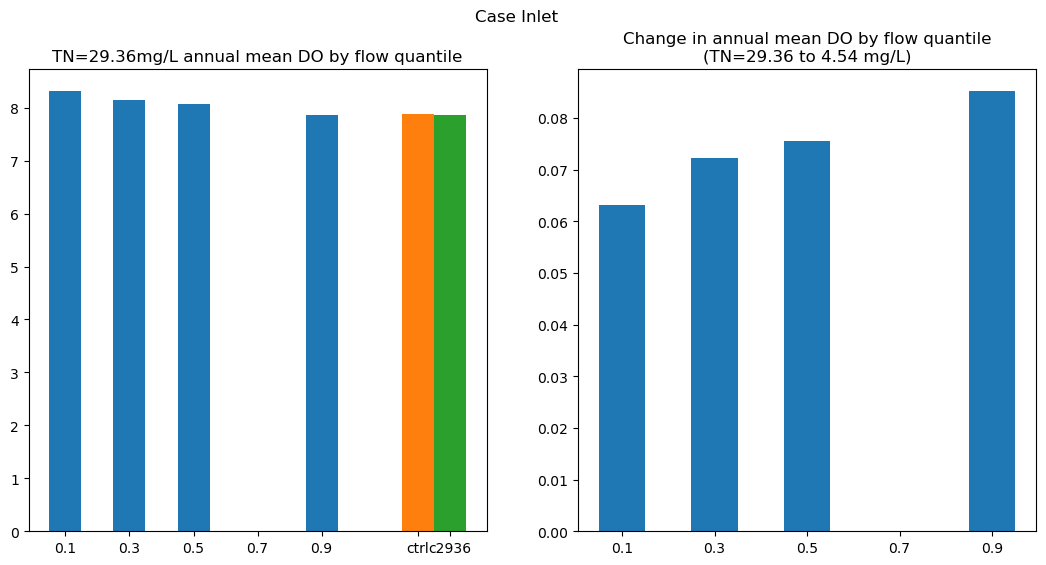

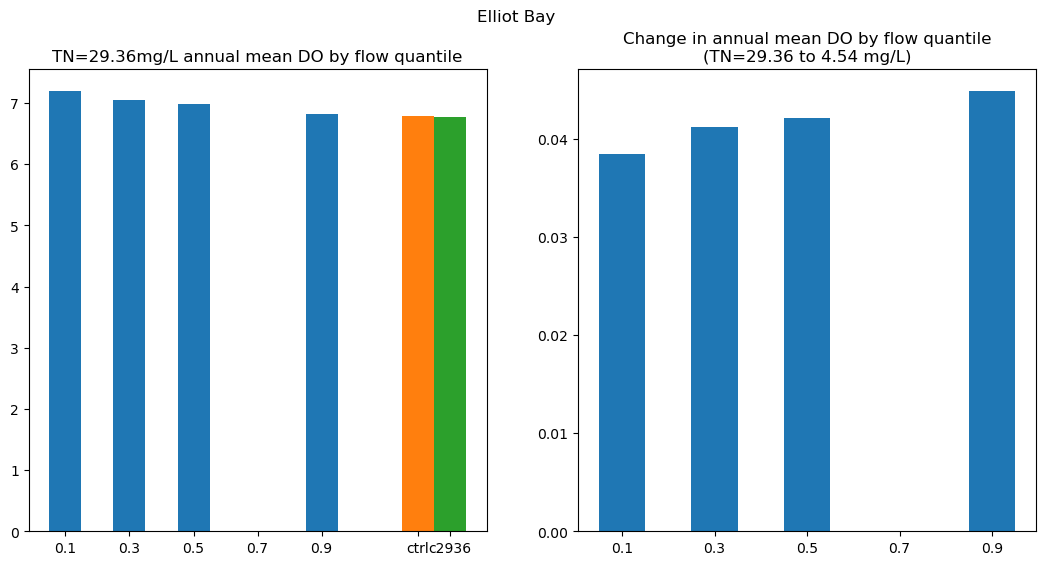

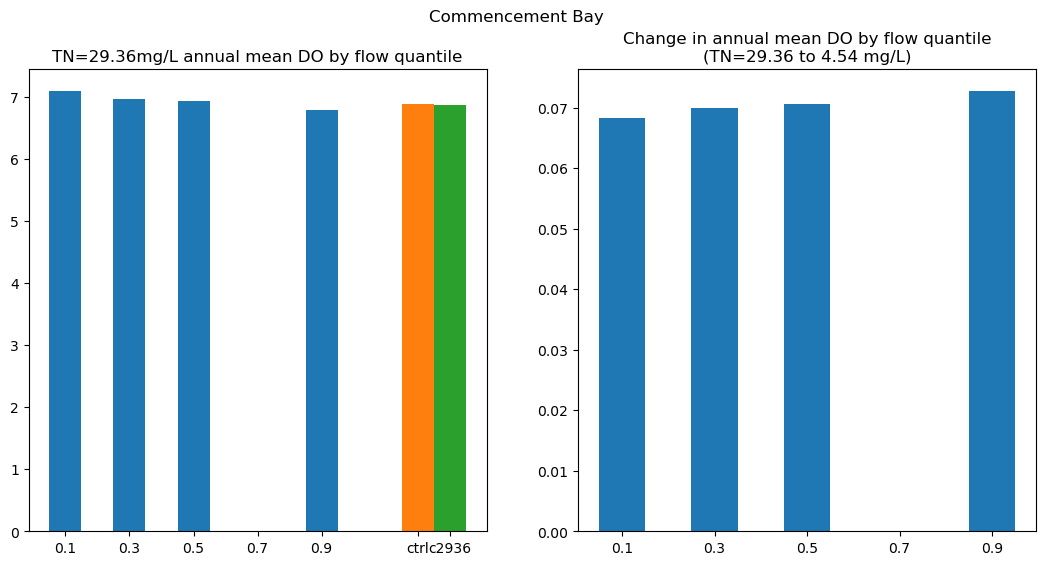

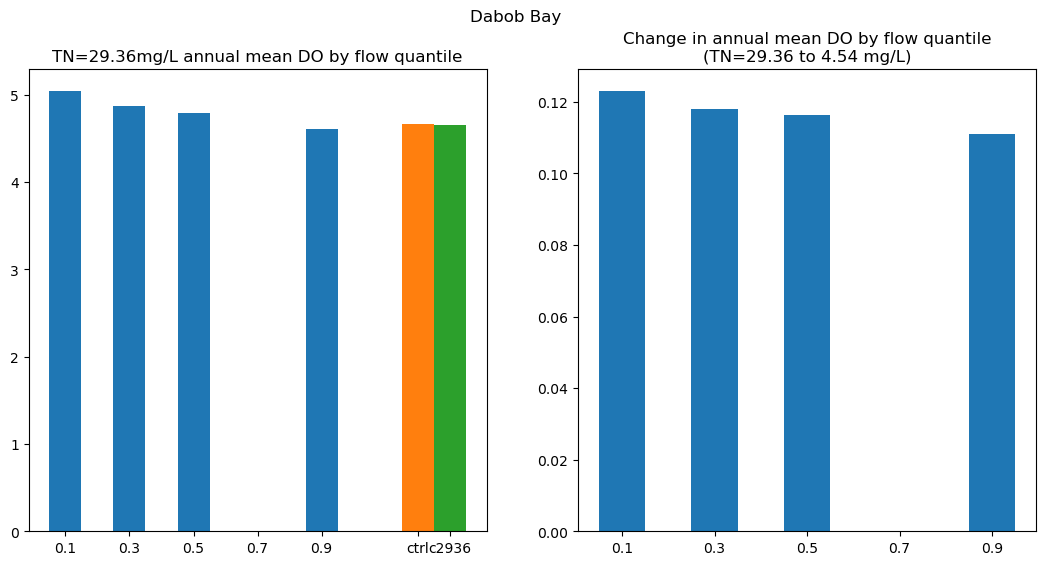

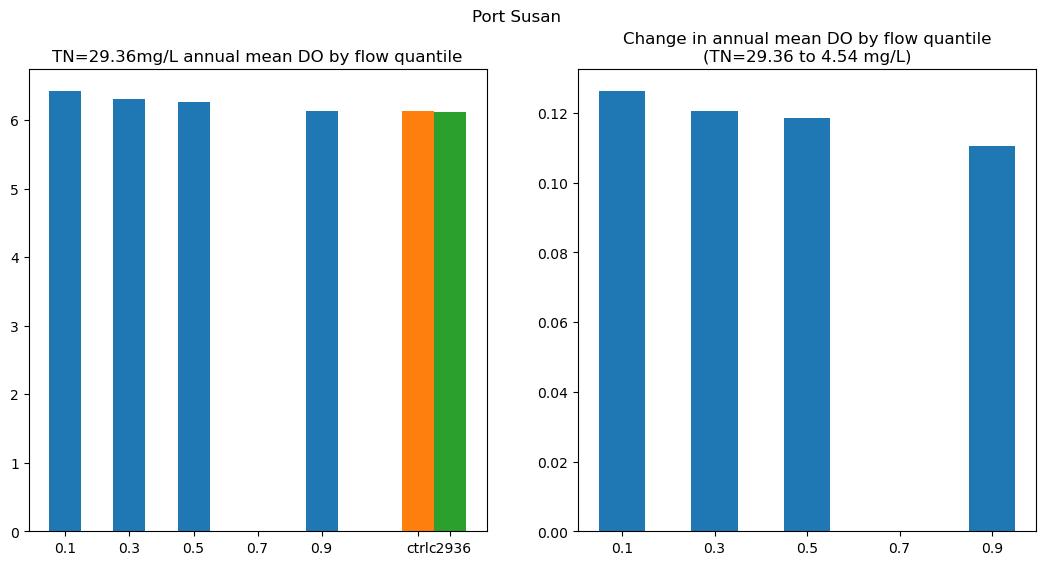

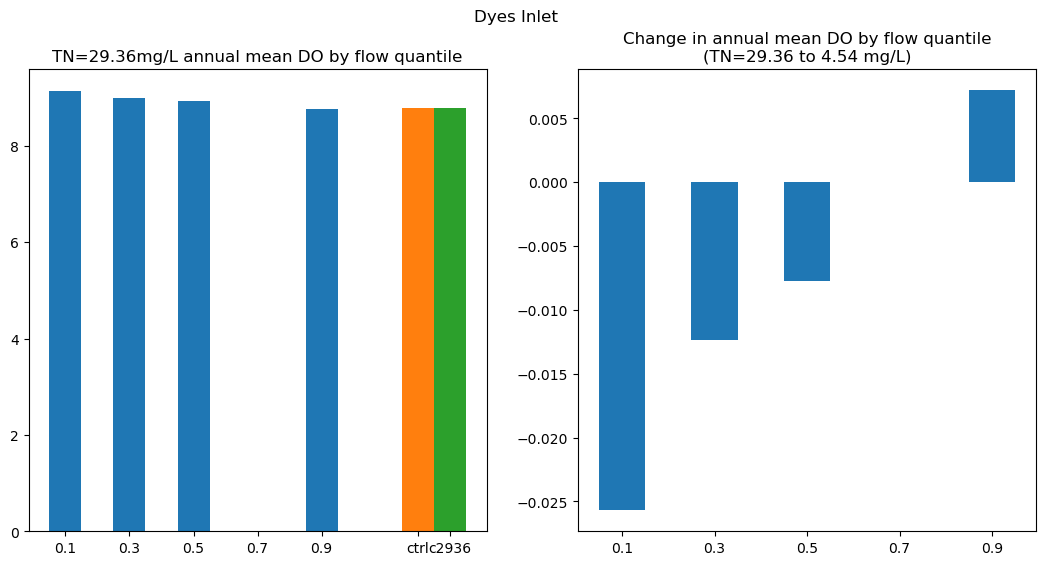

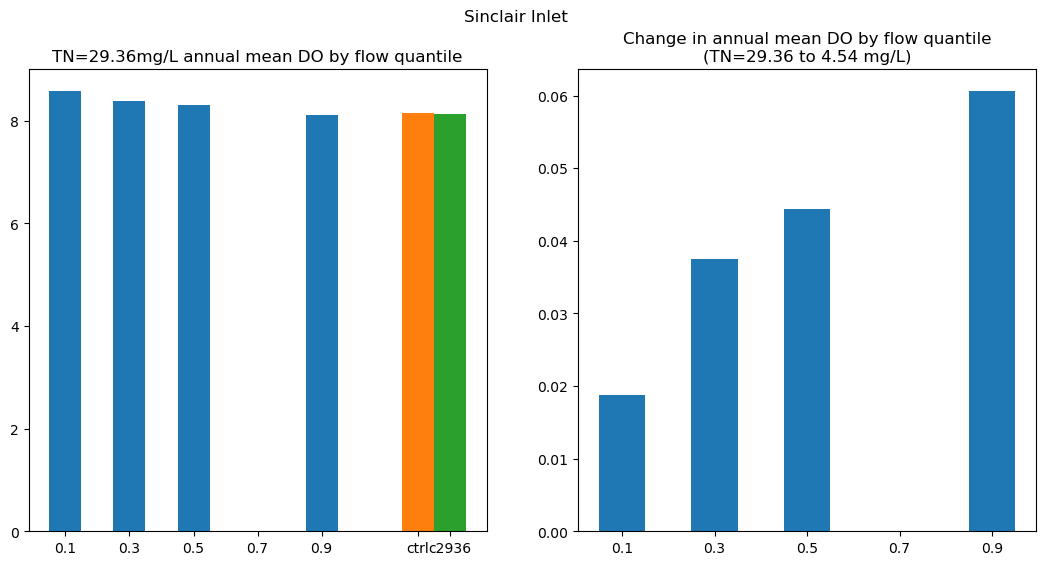

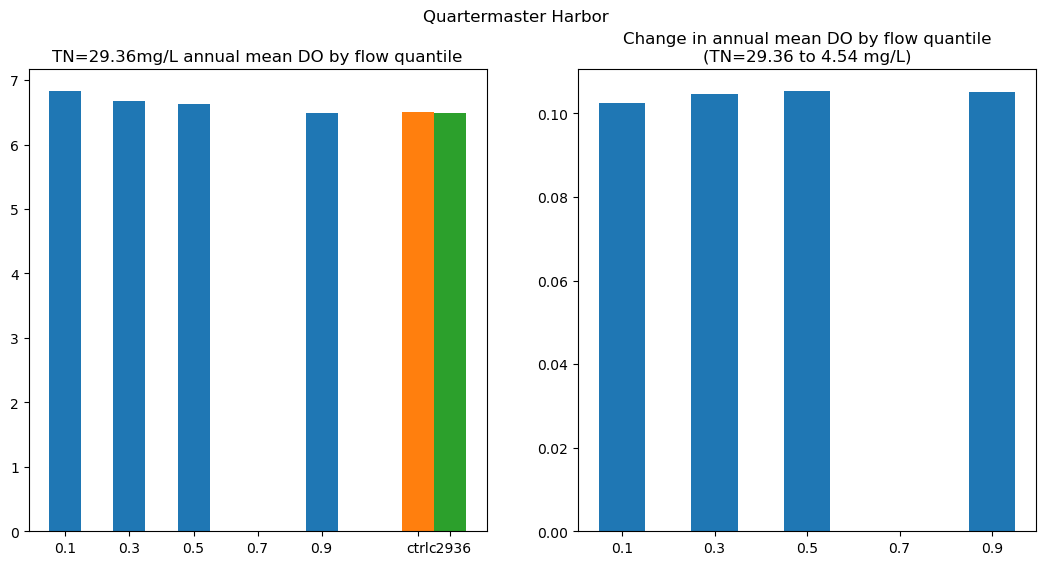

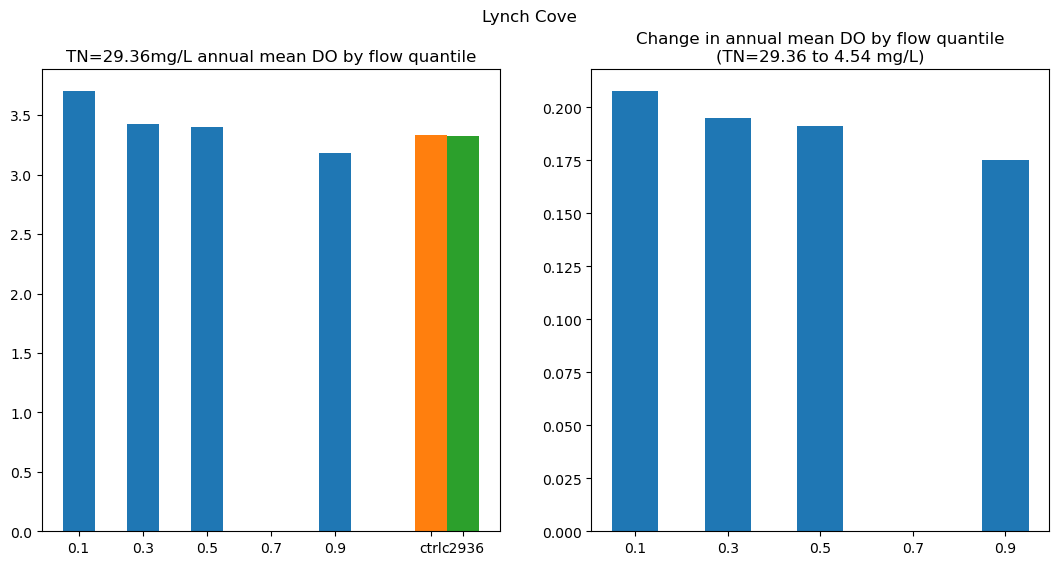

In [46]:
qs = np.array([1,3,5,7,9])
for cvname,cv in cvs.items():
    fig, axs = plt.subplots(1, 2, figsize=(13,6))
    df = mindo_avgs_by_cv[cvname]
    doavgs = [df[f'q{q}c2936'].mean() if f'q{q}c2936' in df.columns else np.nan for q in qs]
    axs[0].bar(qs/10, doavgs, width=0.1)
    axs[0].bar([1.2], [mindo_avgs_by_cv[cvname]['control'].mean()], width=0.1)
    axs[0].bar([1.3], [mindo_avgs_by_cv[cvname]['c2936'].mean()], width=0.1)
    axs[0].set_xticks((qs / 10).tolist() + [1.2,1.3], (qs / 10).tolist() + ['ctrl','c2936'])
    axs[0].set_title(f'TN=29.36mg/L annual mean DO by flow quantile')
    dodeltas = [df[f'q{q}c454'].mean() - df[f'q{q}c2936'].mean() if f'q{q}c2936' in df.columns and f'q{q}c454' in df.columns else np.nan for q in qs]
    axs[1].bar(qs/10, dodeltas, width=0.1)
    axs[1].set_title('Change in annual mean DO by flow quantile\n(TN=29.36 to 4.54 mg/L)')
    axs[1].set_xticks((qs / 10).tolist())
    fig.suptitle(cvname)

'No hypoxia for Holmes Harbor'

'No hypoxia for Crescent Bay'

'No hypoxia for Carr Inlet'

'No hypoxia for Case Inlet'

'No hypoxia for Elliot Bay'

'No hypoxia for Commencement Bay'

'No hypoxia for Dyes Inlet'

'No hypoxia for Quartermaster Harbor'

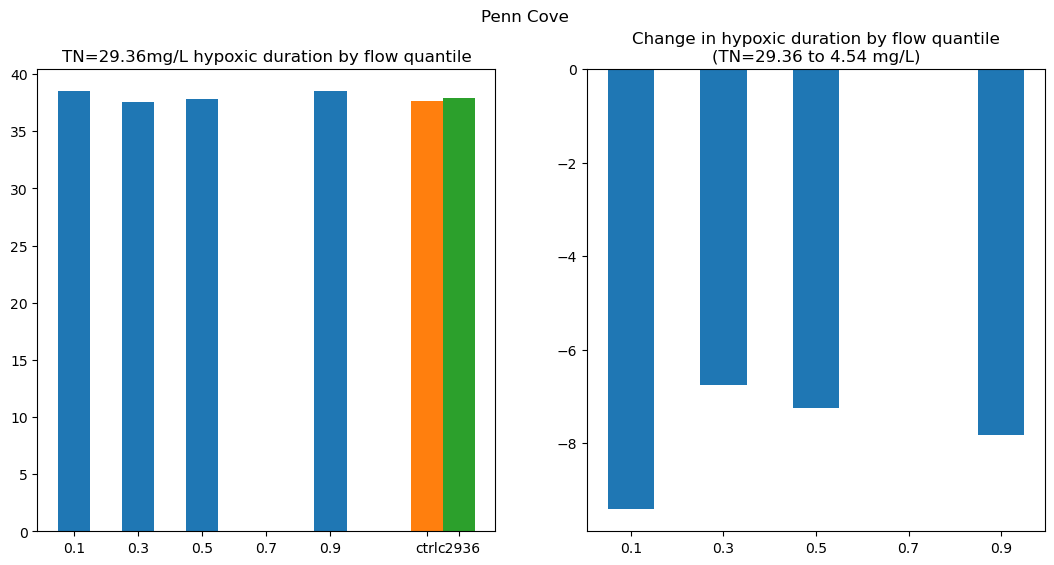

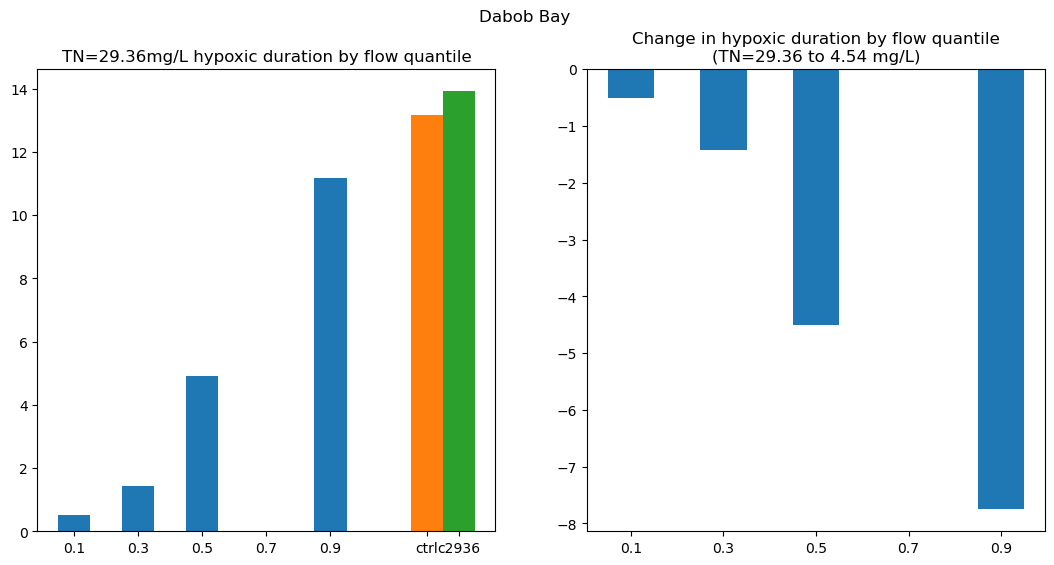

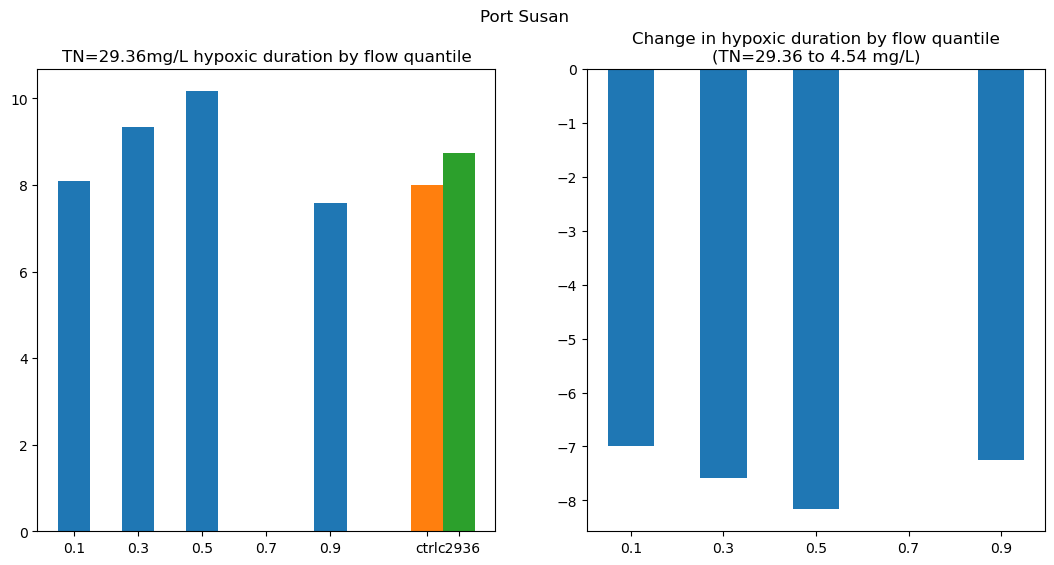

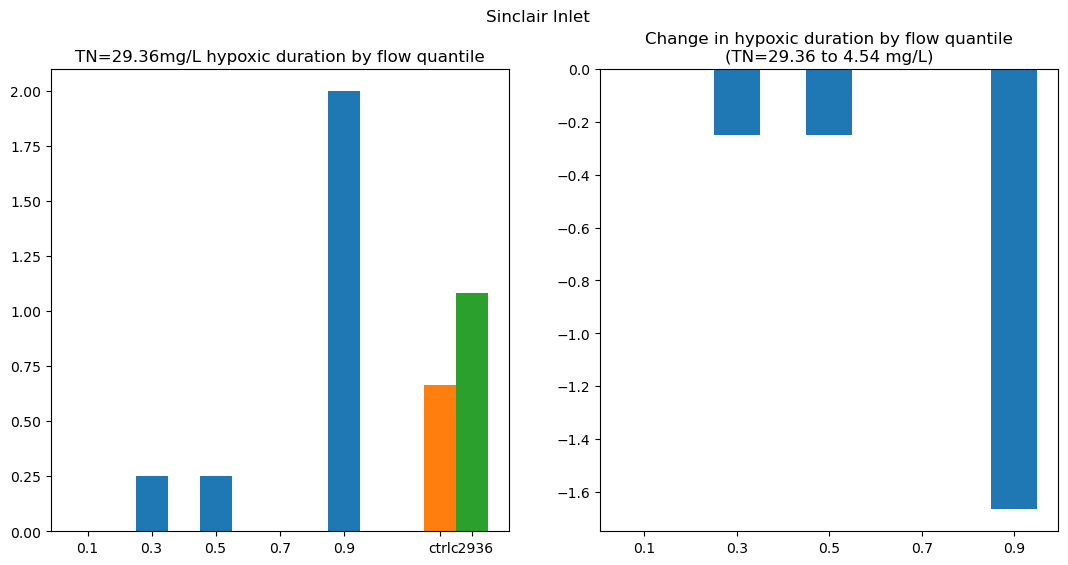

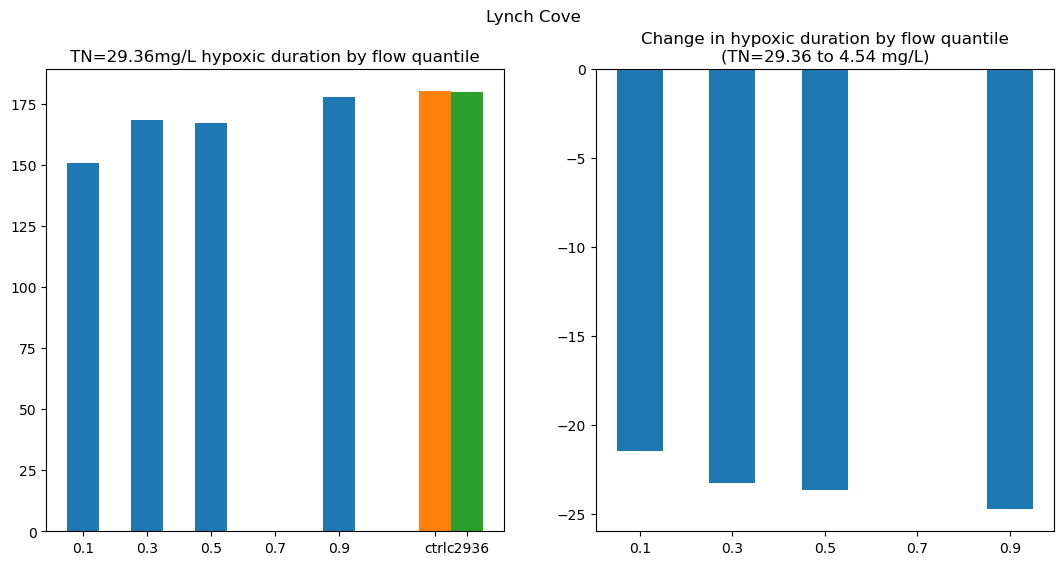

In [47]:
for cvname,cv in cvs.items():
    if durations_df[cvname].max() == 0:
        display(f'No hypoxia for {cvname}')
        continue
    fig, axs = plt.subplots(1, 2, figsize=(13,6))
    durations = [durations_df.loc[f'q{q}c2936', cvname] if f'q{q}c2936' in durations_df.index else np.nan for q in qs]
    axs[0].bar(qs/10, durations, width=0.1)
    axs[0].bar([1.2], [durations_df.loc['control', cvname]], width=0.1)
    axs[0].bar([1.3], [durations_df.loc['c2936', cvname]], width=0.1)
    axs[0].set_xticks((qs / 10).tolist() + [1.2,1.3], (qs / 10).tolist() + ['ctrl','c2936'])
    axs[0].set_title(f'TN=29.36mg/L hypoxic duration by flow quantile')
    deltas = [durations_df.loc[f'q{q}c454', cvname] - durations_df.loc[f'q{q}c2936', cvname] if f'q{q}c2936' in durations_df.index and f'q{q}c454' in durations_df.index else np.nan for q in qs]
    axs[1].bar(qs/10, deltas, width=0.1)
    axs[1].set_title('Change in hypoxic duration by flow quantile\n(TN=29.36 to 4.54 mg/L)')
    axs[1].set_xticks((qs / 10).tolist())
    fig.suptitle(cvname)

In [87]:
data.close()